In [34]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)
# LENA already has CVC

# Add pitch
# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
human_measures = clean_pitch_concatenation(human_measures)

def group_data(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    data = data.groupby('recording_filename').agg({
        '5s_CTC': 'sum',
        'voc_dur_chi': 'sum',
        'voc_chi': 'sum',
        'wc_adu': 'sum',
        'CVC': 'sum',
        'group_id': 'first',
        'child_id': 'first'
    }).reset_index()
    return data
    
aclew_measures = group_data(aclew_measures)
lena_measures = group_data(lena_measures)
human_measures = human_measures.groupby('recording_filename').agg({
    '5s_CTC': 'sum',
    'voc_dur_fem': 'sum',
    'voc_dur_mal': 'sum',
    'voc_dur_och': 'sum',
    'voc_dur_chi': 'sum',
    'overlap_dur': 'sum',
    'voc_chi': 'sum',
    'wc_adu': 'sum',
    'CVC': 'sum',
    'can_voc_dur_CHI': 'sum',
    'non_can_voc_dur_CHI': 'sum',
    'cry_voc_dur_CHI': 'sum',
    'pitch': 'sum',
    'group_id': 'first',
    'child_id': 'first'
}).reset_index()

human_measures['speechlike_voc_dur_CHI'] = human_measures['can_voc_dur_CHI'] + human_measures['non_can_voc_dur_CHI']

def safe_median(x):
        return np.nan if len(x) == 0 else np.median(x)
human_measures['median_pitch'] = human_measures['pitch'].map(safe_median)
human_measures = human_measures.rename(columns={'5s_CTC': 'CTC','wc_adu': 'AWC'})
aclew_measures = aclew_measures.rename(columns={'5s_CTC': 'CTC','wc_adu': 'AWC'})
lena_measures = lena_measures.rename(columns={'5s_CTC': 'CTC','wc_adu': 'AWC'})
# Compute mean and mean percentage error
def compute_me(x, y):
    """ Compute mean error """
    me_list = (x-y).values
    return me_list

def compute_mpe(x, y):
    """ Compute mean error """
    errors = np.zeros_like(x, dtype=float)
    # Case 1: y != 0 - standard MPE calculation
    mask_nonzero = (y != 0)
    errors[mask_nonzero] = (x[mask_nonzero] - y[mask_nonzero]) / y[mask_nonzero]
    # Case 2: y = 0 and x != 0 -> error = 1
    mask_zero_error = (y == 0) & (x != 0)
    errors[mask_zero_error] = 1
    # Case 3: y = 0 and x = 0 -> error = 0 is already handled by initialization
    return 100*errors

cols = ['CTC', 'AWC', 'CVC']
lena_scores, aclew_scores = pd.DataFrame(), pd.DataFrame()
for col in cols:
    lena_scores[f'{col}_me'] = compute_me(lena_measures[col], human_measures[col])
    lena_scores[f'{col}_mpe'] = compute_mpe(lena_measures[col], human_measures[col])
    aclew_scores[f'{col}_me'] = compute_me(aclew_measures[col], human_measures[col])
    aclew_scores[f'{col}_mpe'] = compute_mpe(aclew_measures[col], human_measures[col])

duration_cols = ['voc_dur_fem', 'voc_dur_mal', 'voc_dur_och', 'voc_dur_chi', 'speechlike_voc_dur_CHI', 'can_voc_dur_CHI', 'non_can_voc_dur_CHI', 'cry_voc_dur_CHI']

for duration_col in duration_cols:
    human_measures[duration_col] /= 1000.0

copy_cols = ['recording_filename', 'group_id', 'child_id', 'voc_dur_fem', 'voc_dur_mal', 'voc_dur_och', 'voc_dur_chi', 
             'AWC', 'CTC', 'overlap_dur', 'CVC', 'speechlike_voc_dur_CHI', 'can_voc_dur_CHI', 'non_can_voc_dur_CHI', 'cry_voc_dur_CHI']
for col in copy_cols:
    lena_scores[col] = human_measures[col]
    aclew_scores[col] = human_measures[col]

# Finally add identification error rate components and percentage correct
results_folder = DATA_PATH / 'results' / 'pyannote_metrics'
ider_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'ider_30mn_clips.csv')
ider_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'ider_30mn_clips.csv')

def compute_ider(ider_df):
    ider_df['missed detection'] = 100*ider_df['missed detection'] / ider_df['total']
    ider_df['false alarm'] = 100*ider_df['false alarm'] / ider_df['total']
    ider_df['confusion'] = 100*ider_df['confusion'] / ider_df['total']
    ider_df['correct'] = 100*ider_df['correct'] / ider_df['total']
    ider_df['ider'] = 100*ider_df['ider']
    return ider_df

ider_vtc = compute_ider(ider_vtc)
ider_lena = compute_ider(ider_lena)
cols = ['recording_id', 'confusion', 'correct', 'missed detection', 'false alarm']
ider_vtc = ider_vtc[cols]
ider_lena = ider_lena[cols]
rename_map = {'missed detection': 'miss', 'false alarm': 'false_alarm'}
ider_vtc = ider_vtc.rename(columns=rename_map)
ider_lena = ider_lena.rename(columns=rename_map)

aclew_scores = aclew_scores.merge(ider_vtc, left_on='recording_filename', right_on='recording_id')
lena_scores = lena_scores.merge(ider_lena, left_on='recording_filename', right_on='recording_id')

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_ANOVA(data, error_vars, predictor_vars):
    df = data.copy()
    
    # Rename variables that start with numbers
    rename_map = {}
    for col in df.columns:
        if col.startswith('5s_'):
            rename_map[col] = col.replace('5s_', 'CTC_')
    
    df = df.rename(columns=rename_map)
    
    # Update variable lists with new names
    updated_error_vars = [rename_map.get(var, var) for var in error_vars]
    updated_predictor_vars = [rename_map.get(var, var) for var in predictor_vars]
    
    # Filter predictors to those that exist in the dataframe
    valid_predictors = [p for p in updated_predictor_vars if p in df.columns]
    
    # Process each error variable
    for error_var in updated_error_vars:
        if error_var not in df.columns:
            print(f"Warning: Variable {error_var} not found in the data")
            continue
        
        # Get the original error variable name for reporting
        original_error_var = next((k for k, v in rename_map.items() if v == error_var), error_var)
        
        print(f"\n=== {original_error_var} ===")
        
        try:
            # Prepare data: remove missing values
            model_data = df[[error_var] + valid_predictors].dropna()
            
            if len(model_data) == 0:
                print(f"Error: No complete data for {original_error_var}")
                continue
            
            # First, get the total sum of squares
            y = model_data[error_var]
            total_ss = np.sum((y - y.mean())**2)
            
            # Fit the full model
            X = model_data[valid_predictors]
            X_with_const = sm.add_constant(X)
            full_model = sm.OLS(y, X_with_const).fit()
            
            # Display model summary - show R² as percentage
            total_variance_explained = full_model.rsquared * 100
            print(f"Total variance explained (R²) = {total_variance_explained:.1f}%, n = {len(X)}")
            
            # Calculate Type II SS ANOVA for each predictor
            results = []
            
            # For each predictor, fit models with and without it
            for predictor in valid_predictors:
                # Fit model without this predictor
                predictors_without_one = [p for p in valid_predictors if p != predictor]
                X_reduced = model_data[predictors_without_one]
                X_reduced_with_const = sm.add_constant(X_reduced)
                reduced_model = sm.OLS(y, X_reduced_with_const).fit()
                
                # Type II SS is the difference in SSR (sum of squared residuals) between models
                # The increased residual error when removing the predictor is its Type II SS
                ss_predictor = reduced_model.ssr - full_model.ssr
                
                # Coefficient from the full model
                coef = full_model.params[predictor]
                
                # Calculate semi-partial R² (sr²) - the unique contribution
                # This is the proportional reduction in total SS when adding this predictor to the reduced model
                semipartial_r2 = (reduced_model.ssr - full_model.ssr) / total_ss
                
                # Calculate F-statistic and p-value
                df_predictor = 1  # For a single predictor
                ms_predictor = ss_predictor / df_predictor
                mse = full_model.ssr / full_model.df_resid
                f_stat = ms_predictor / mse
                
                import scipy.stats as stats
                p_value = 1 - stats.f.cdf(f_stat, df_predictor, full_model.df_resid)
                
                # Format significance
                if p_value < 0.001:
                    sig = "***"
                    p_value_str = "<0.001***"
                elif p_value < 0.01:
                    sig = "**"
                    p_value_str = f"{p_value:.3f}**"
                elif p_value < 0.05:
                    sig = "*"
                    p_value_str = f"{p_value:.3f}*"
                else:
                    sig = ""
                    p_value_str = f"{p_value:.3f}"
                
                results.append({
                    'Predictor': predictor,
                    'Coefficient (β)': coef,
                    'p-value': p_value_str,
                    'p-value-raw': p_value,  # Used for sorting, won't be displayed
                    'Unique Variance Explained (%)': semipartial_r2 * 100
                })
            
            # Convert to dataframe and sort by variance explained
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Unique Variance Explained (%)', ascending=False)
            
            formatted_df = results_df.copy()
            formatted_df['Coefficient (β)'] = formatted_df['Coefficient (β)'].apply(lambda x: f"{x:.3f}")
            formatted_df['Unique Variance Explained (%)'] = formatted_df['Unique Variance Explained (%)'].apply(lambda x: f"{x:.1f}%")
            
            print("\nTable: Predictors of measurement error in automated speech processing")
            print(formatted_df[['Predictor', 'Coefficient (β)', 'p-value', 'Unique Variance Explained (%)']].to_string(index=False))
            
            print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")
                
        except Exception as e:
            import traceback
            print(f"Error analyzing {original_error_var}: {str(e)}")
            print(traceback.format_exc())

error_vars = ['miss', 'false_alarm', 'confusion', 'correct', 'CTC_mpe', 'AWC_mpe', 'CVC_mpe']
 
predictor_vars = [
    'voc_dur_fem', 'voc_dur_mal', 'voc_dur_och', 'voc_dur_chi',
    'wc_adu', '5s_CTC', 'overlap_dur', 'CVC', 
    'speechlike_voc_dur_CHI', 'can_voc_dur_CHI', 'non_can_voc_dur_CHI', 'cry_voc_dur_CHI'
    ]

# Simplified analysis for publication
print("LENA")
results = analyze_ANOVA(lena_scores, error_vars, predictor_vars)
 
print("ACLEW")
results = analyze_ANOVA(aclew_scores, error_vars, predictor_vars)

LENA

=== miss ===
Total variance explained (R²) = 37.3%, n = 50

Table: Predictors of measurement error in automated speech processing
             Predictor Coefficient (β) p-value Unique Variance Explained (%)
           voc_dur_och           0.051   0.070                          5.4%
           voc_dur_mal          -0.057   0.080                          5.1%
           voc_dur_fem          -0.031   0.111                          4.2%
       cry_voc_dur_CHI          -0.220   0.295                          1.8%
                   CVC          -0.045   0.300                          1.7%
           voc_dur_chi           0.160   0.421                          1.0%
           overlap_dur           0.000   0.624                          0.4%
speechlike_voc_dur_CHI          -0.119   1.000                          0.0%
       can_voc_dur_CHI          -0.081   1.000                         -0.0%
   non_can_voc_dur_CHI          -0.038   1.000                         -0.0%

* p < 0.05, ** p

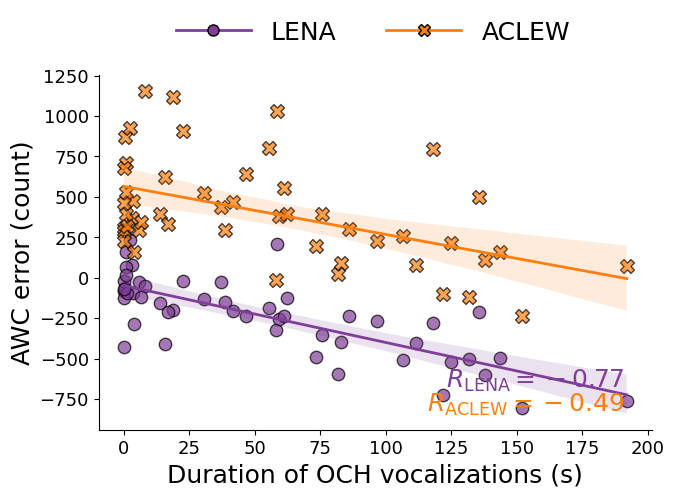

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib

matplotlib.rcParams.update({'font.size': 18, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

def plot_volubility_scatter(lena_df, aclew_df, y_metric, x_measure, save_path=None):
    """
    Create scatter plot with regression lines for LENA and ACLEW data.
    
    Parameters:
    -----------
    lena_df : pandas DataFrame
        DataFrame containing LENA scores
    aclew_df : pandas DataFrame
        DataFrame containing ACLEW scores
    y_metric : str
        Column name for the y-axis (performance metric)
    x_measure : str
        Column name for the x-axis (child measure)
    save_path : str, optional
        Path to save the figure, if None the figure is not saved
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    x_name = {
        'can_voc_dur_CHI': 'Canonical duration (s)',
        'cp_dur': 'Canonical duration proportion (%)',
        'can_voc_CHI': 'Number of canonical segments',
        'voc_dur_och': 'Duration of OCH vocalizations (s)'
    }

    y_name = {
        '5s_CTC': 'CTC',
        'wc_adu': 'AWC',
        'CVC': 'CVC',
        'AWC': 'AWC',
    }
    metric_name = {
        'me': 'error (count)',
        'mpe': 'percentage error (%)'
        } 

    x_label = x_name[x_measure]
    y_label = y_name['_'.join(y_metric.split('_')[:-1])] + ' ' + metric_name[y_metric.split('_')[-1]]
    # Define colors
    lena_color = '#7F3E97'
    aclew_color = '#ff7f0e'
    cm = 1/2.54
    
    # Create figure
    fig, ax = plt.subplots(figsize=(18*cm, 12*cm))
    
    # Plot LENA data with regression line and confidence interval
    sns.regplot(x=x_measure, y=y_metric, data=lena_df, 
                scatter_kws={'color': lena_color, 'alpha': 0.7, 's': 80, 'edgecolor': 'black', 'marker': 'o'},
                line_kws={'color': lena_color, 'lw': 2},
                ax=ax, ci=95)
    
    # Plot ACLEW data with regression line and confidence interval
    sns.regplot(x=x_measure, y=y_metric, data=aclew_df, marker='X',
                scatter_kws={'color': aclew_color, 'alpha': 0.7, 's': 100, 'edgecolor': 'black'},
                line_kws={'color': aclew_color, 'lw': 2},
                ax=ax, ci=95)

    # Calculature correlation statistics for LENA
    lena_mask = ~np.isnan(lena_df[x_measure]) & ~np.isnan(lena_df[y_metric])
    lena_corr, lena_p = stats.pearsonr(lena_df.loc[lena_mask, x_measure], lena_df.loc[lena_mask, y_metric])
    lena_corr_text =  f'$R_{{\\mathrm{{LENA}}}} = {lena_corr:.2f}$'
  
    # Calculate correlation statistics for ACLEW
    aclew_mask = ~np.isnan(aclew_df[x_measure]) & ~np.isnan(aclew_df[y_metric])
    aclew_corr, aclew_p = stats.pearsonr(aclew_df.loc[aclew_mask, x_measure], aclew_df.loc[aclew_mask, y_metric])
    aclew_corr_text = f'$R_{{\\mathrm{{ACLEW}}}} = {aclew_corr:.2f}$'
   
    
    # Add correlation text
    ax.text(0.95, 0.12, lena_corr_text, 
            transform=ax.transAxes, color=lena_color,
            fontweight='bold', horizontalalignment='right')
    ax.text(0.95, 0.05, aclew_corr_text, 
            transform=ax.transAxes, color=aclew_color, 
            fontweight='bold', horizontalalignment='right')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color=lena_color, marker='o', label='LENA', lw=2, 
               markersize=8, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label='ACLEW', lw=2, 
               markersize=8, markerfacecolor=aclew_color, markeredgecolor='black')
    ]
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.55, 1.02), 
               loc='center', frameon=False, handlelength=3)
    
    plt.tight_layout()

    return fig, ax

#y_metrics = ['5s_CTC_me', '5s_CTC_mpe', 'wc_adu_me', 'wc_adu_mpe', 'CVC_me', 'CVC_mpe']
y_metrics = ['AWC_me']
x_measures = ['voc_dur_och']

for y_metric in y_metrics:
    for x_measure in x_measures:
        fig, ax = plot_volubility_scatter(lena_scores, aclew_scores, y_metric=y_metric, x_measure=x_measure)
        plt.savefig(f'/home/engaclew/neurogen/figures/volubility/{y_metric}_asf_{x_measure}.png', dpi=300, bbox_inches='tight')
        plt.show()



LENA

=== CTC_me ===
Total variance explained (R²) = 87.7%, n = 50

Table: Predictors of measurement error in automated speech processing
             Predictor Coefficient (β)   p-value Unique Variance Explained (%)
                   CVC          -0.566 <0.001***                         12.3%
           voc_dur_fem          -0.194 <0.001***                          7.2%
           voc_dur_mal          -0.256 <0.001***                          4.5%
           voc_dur_och           0.115     0.056                          1.2%
           overlap_dur          -0.001     0.199                          0.5%
           voc_dur_chi          -0.270     0.520                          0.1%
       cry_voc_dur_CHI          -0.090     0.838                          0.0%
       can_voc_dur_CHI           0.205     1.000                          0.0%
speechlike_voc_dur_CHI           0.330     1.000                          0.0%
   non_can_voc_dur_CHI           0.125     1.000                        